In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import networkx as nx
import re

from tabulate import tabulate
from collections import defaultdict
import matplotlib.pyplot as plt

## reading, exploring & processing data

In [2]:
#import data from csv

edges = pd.read_csv('edges.csv')
nodes = pd.read_csv('nodes.csv')
hero_edges = pd.read_csv('hero-network.csv')

# edges = pd.read_csv('data/edges.csv')
# nodes = pd.read_csv('data/nodes.csv')
# hero_edges = pd.read_csv('data/hero-network.csv')

datasets = [edges, nodes, hero_edges]

In [3]:
hero_edges.describe()

,hero1,hero2
count,574467,574467
unique,6211,6173
top,CAPTAIN AMERICA,CAPTAIN AMERICA
freq,8149,8350


In [4]:
#Let's display the number of different nodes (comic/hero)
pd.DataFrame(nodes.type.value_counts())

,type
comic,12651
hero,6439


- **DATA CLEANING**

In [5]:
# preprocessing
def strip_rightend(string):
    string = string.strip().rstrip('/')

    if string =='SPIDER-MAN/PETER PARKER':
        string = 'SPIDER-MAN/PETER PAR'
    elif string == 'SPIDER-MAN/PETER PARKERKER':
        string = 'SPIDER-MAN/PETER PAR'

    return string

In [6]:
for ds in datasets:
    ds.dropna(inplace=True)
    for col in ds.columns:
        ds[col] = ds[col].apply(lambda row: strip_rightend(row))

In [7]:
hero_edges_arr = np.array(hero_edges)
hero_edges_arr.shape

(574467, 2)

In [8]:
idx_self = np.where(hero_edges_arr[:,0] == hero_edges_arr[:,1])
idx_self
# we check on a sample
hero_edges.iloc[8889]

hero1    MISS AMERICA/MADELIN
hero2    MISS AMERICA/MADELIN
Name: 8889, dtype: object

In [9]:
hero_edges_arr = np.delete(hero_edges_arr, idx_self, axis = 0) # delete the self referring rows by their index
print(hero_edges_arr.shape) # 574467 down to 572235
heroes_df = pd.DataFrame(hero_edges_arr) # ! new df 
heroes_df.columns = ['hero1', 'hero2']

(572235, 2)


- *FIRST GRAPH*

In [10]:
heroes = nx.from_pandas_edgelist(heroes_df, 'hero1', 'hero2', create_using=nx.Graph)

In [11]:
node_count = heroes_df.groupby(['hero1','hero2'])['hero1','hero2'].size()#.apply(lambda row: print(row))

fl = np.power(np.array(list(map(float, node_count.values))), -1)

weights = dict( list(zip (node_count.index, fl) ) )

C:\Users\Admin\AppData\Local\Temp\ipykernel_8872\1918835698.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  node_count = heroes_df.groupby(['hero1','hero2'])['hero1','hero2'].size()#.apply(lambda row: print(row))


In [12]:
node_tuple_weight = {}
for e in heroes.edges: # 
    try:
        weight = weights[(e[0], e[1])]
    except:
        weight = weights[(e[1], e[0])]

    node_tuple_weight[(e[0], e[1])] = weight

In [13]:
nx.set_edge_attributes(heroes, values = node_tuple_weight, name = 'weight')

In [14]:
nx.degree_centrality(heroes)
pd.DataFrame.from_dict(nx.betweenness_centrality(heroes,k= 10), orient='index', columns=['betweenness']).sort_values(by='betweenness', ascending=False).head(10)

,betweenness
SPIDER-MAN/PETER PAR,0.095645
DR. STRANGE/STEPHEN,0.080923
DAREDEVIL/MATT MURDO,0.059276
THING/BENJAMIN J. GR,0.043533
HAWK,0.043216
MR. FANTASTIC/REED R,0.043145
HUMAN TORCH/JOHNNY S,0.040536
BEAST/HENRY &HANK& P,0.039474
"WATSON-PARKER, MARY",0.039101
INVISIBLE WOMAN/SUE,0.036079


- SECOND GRAPH

In [16]:
# node_data = list(zip(nodes.node, [t for t in nodes.type]))
node_data = list(zip(datasets[1].node, [{'type':t}for t in datasets[1].type]))
edge_data = list(zip(datasets[0].hero, datasets[0].comic))

In [17]:
# modify edge data to be only included if nodes also in node_data
# TODO: after adding peter par par in preprocessing this might be redundant 

edge_arr = np.array(edge_data)
print(edge_arr.shape)
node_list = list(nodes.node)

tbd = []

for i in range(len(edge_arr)):
    a, b = edge_arr[i,0], edge_arr[i,1]
    if a not in node_list or b not in node_list:
        tbd.append(i)

edge_arr = np.delete(edge_arr, tbd, axis = 0)
print(edge_arr.shape)

edges_cleaned = pd.DataFrame(edge_arr)
edges_cleaned.columns = ['hero', 'comic'] # needed to establish top hero

# edge_data = [(e[0], e[1])for e in edge_arr.tolist()] # again format of list of tuples
# TODO: think output is same but bottom line easier

edge_data = list(zip(edges_cleaned.hero, edges_cleaned.comic))

(96104, 2)
(96104, 2)


In [18]:
#build the graph
comics=nx.Graph()

# Add nodes to the graph
comics.add_nodes_from(node_data)

# for node, node_type in node_data:
#    comics.add_node(node, type=node_type) 
    
# Add edges to the graph
comics.add_edges_from(edge_data)

#check the type
comics.nodes['2001 10']['type']

'comic'

In [19]:
# making list of top_n sorted heroes
ls = edges_cleaned.groupby(by = 'hero')['comic'].size().sort_values(ascending=False)
top_n_heroes = np.array(list(zip(ls.index, ls.values)) )

# Functionality 1

FUNCTIONALITY 1



Output:

- The number of nodes in the network (if type 2, report for both node types)

- The number of collaborations of each superhero with the others (only if type 1)

- The number of heroes that have appeared in each comic (only if type 2)

- The network's density

- The network's degree distribution

- The average degree of the network

- The network's Hubs (hubs are nodes having degrees more extensive than the 95th percentile of the degree distribution)
Whether the Network is sparse or dense

In [201]:
# making list of top_n sorted heroes
ls = edges_cleaned.groupby('hero')['comic'].count().sort_values(ascending=False).reset_index().head(10)
ls

,hero,comic
0,SPIDER-MAN/PETER PAR,1577
1,CAPTAIN AMERICA,1334
2,IRON MAN/TONY STARK,1150
3,THING/BENJAMIN J. GR,963
4,THOR/DR. DONALD BLAK,956
5,HUMAN TORCH/JOHNNY S,886
6,MR. FANTASTIC/REED R,854
7,HULK/DR. ROBERT BRUC,835
8,WOLVERINE/LOGAN,819
9,INVISIBLE WOMAN/SUE,762


In [202]:
#build a function to extract the nodes that are not in the top N

def Remove_Not_TopN(graph,N):
    #build the first part of the function to extract the nodes(heroes) that are not in the top N

    top = edges_cleaned.groupby('hero')['comic'].count().sort_values(ascending=False).index
    not_top_heroes = list(top[N:])
    
    #let's copy our graph in order to remove the heroes(node) that are not in top N 

    subgraph=graph.copy()
    subgraph.remove_nodes_from(not_top_heroes) 
    return(subgraph)


#check 
graph_without_notTopN= Remove_Not_TopN(heroes,100) 
nx.info(graph_without_notTopN)
nx.density(graph_without_notTopN) #dense graph 

C:\Users\Admin\AppData\Local\Temp\ipykernel_12836\238848.py:18: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(graph_without_notTopN)


0.8141414141414142

In [203]:
#1)     #The number of nodes in the network (if type 2, report for both node types)
def n_nodes_N(graph,type_):  
    if type_== 1:
        print('the number of nodes of the original network is '+ str(graph.number_of_nodes()), end='\n')

    elif type_==2:

        comic=[x for x in graph.nodes if graph.nodes[x]['type']=="comic"]
        print('the number of hero-nodes is '+ str(len(comic)))
        hereos=[x for x in graph.nodes if graph.nodes[x]['type']=='hero']
        print('the number of comic-nodes is '+ str(len(hereos)))

#check
n_nodes_N(comics,2)

the number of hero-nodes is 12648
the number of comic-nodes is 6439


In [204]:
#2) The number of collaborations of each hero with the others 

def collaborations(graph,type_):
    if type_ == 1:
        collabor=dict(graph.degree())
        collab=dict(sorted(collabor.items(),key=lambda x: -x[1]))
    #let's print just the first 25 pairs of the dictionary:
        count = 0
        for key, value in collab.items():
            print(f'{key}: {value}')
            count += 1
            if count >= 10:
                break
                  
                
#3) this request can be interpreted as find the degree of each 'comic'-node 
def hero_appearance(graph,type_):
    #dictionary comprehension 
    if  type_==2:
        comic={x: graph.degree[x] for x in graph.nodes if graph.nodes[x]['type']=='comic'}
        comic
        # sort the dictionary by values and store the result as a dataframe
        sort_dict = sorted(comic.items(), key=lambda x: -x[1])
        top10_comic_degree= pd.DataFrame(sort_dict).head(10)

    return(top10_comic_degree.rename(columns={0: 'Comic', 1: 'Degree'}))



#construct a function to call one of the previous two depending on the type of graph given as input
def collaborations_appearances(graph,type_):
    if type_==1:
        print('The number of collaborations of each superhero with the others is: ')
        collaborations(graph,1)
    elif type_==2:
        print('The number of heroes that have appeared in each comic is: ')
        print(hero_appearance(graph,2))
        

In [205]:
collaborations_appearances(comics,2)

The number of heroes that have appeared in each comic is: 
      Comic  Degree
0     COC 1     111
1      IW 3      91
2      IW 1      90
3    H2 279      87
4      IW 4      80
5      IW 2      76
6  MAXSEC 3      72
7    FF 370      62
8      IW 6      60
9    M/GN 1      60


In [206]:
#4) density of the graph

def density(graph):
    dens = nx.density(graph)
    print('The Density of the graph is ' + str(round(dens,4)))


#check
density(comics)

The Density of the graph is 0.0005


In [207]:
#5) EXTRACT NETWORK'S DEGREE DISTRIBUTION

#To extract the degree distribution of the graph we have to iterate through all the nodes and count 
#for each node its number of edges(degree), then we will use the degree as the key and the number of 
#nodes with that degree as the value in the dictionary

def degree_distribution(graph):
    degree_count={}
    for node in graph.nodes():
        degree=graph.degree(node)
        if degree not in degree_count:  #if the degree of the node it's not even encountred before assign 1
            degree_count[degree] = 1
        else:
            degree_count[degree] += 1 #if the degree has already been encountered, increment the value by 1.
            
    output=dict(sorted(degree_count.items())) #degree distribution sorted by keys (degrees of the nodes)
    print(output)
#claim that in this dict we have as key the various degrees of node and as values the number of nodes that have that degree


In [208]:
degree_distribution(heroes)

{1: 52, 2: 86, 3: 104, 4: 150, 5: 182, 6: 178, 7: 185, 8: 230, 9: 224, 10: 246, 11: 254, 12: 186, 13: 193, 14: 160, 15: 193, 16: 123, 17: 143, 18: 123, 19: 109, 20: 131, 21: 118, 22: 84, 23: 94, 24: 85, 25: 111, 26: 70, 27: 85, 28: 64, 29: 72, 30: 65, 31: 49, 32: 43, 33: 46, 34: 56, 35: 44, 36: 45, 37: 39, 38: 60, 39: 61, 40: 38, 41: 46, 42: 39, 43: 30, 44: 38, 45: 27, 46: 39, 47: 20, 48: 57, 49: 33, 50: 30, 51: 18, 52: 21, 53: 20, 54: 27, 55: 25, 56: 25, 57: 18, 58: 24, 59: 30, 60: 25, 61: 22, 62: 14, 63: 10, 64: 22, 65: 20, 66: 20, 67: 16, 68: 23, 69: 22, 70: 16, 71: 14, 72: 14, 73: 28, 74: 10, 75: 6, 76: 13, 77: 17, 78: 16, 79: 21, 80: 13, 81: 16, 82: 7, 83: 11, 84: 14, 85: 11, 86: 16, 87: 11, 88: 8, 89: 18, 90: 11, 91: 9, 92: 9, 93: 6, 94: 12, 95: 5, 96: 9, 97: 8, 98: 8, 99: 4, 100: 9, 101: 6, 102: 8, 103: 3, 104: 4, 105: 7, 106: 9, 107: 4, 108: 8, 109: 6, 110: 10, 111: 6, 112: 3, 113: 4, 114: 5, 115: 2, 116: 4, 117: 7, 118: 9, 119: 6, 120: 11, 121: 2, 122: 8, 123: 9, 124: 5, 125: 

In [209]:
#6)  # Calculate the average degree of the graph
def avg_G(graph):
    average_degree = sum(d for n, d in graph.degree()) / graph.number_of_nodes()
    print("Average degree of the graph: "+str(round(average_degree,3)))
avg_G(comics)    

Average degree of the graph: 10.07


In [210]:
#7) 
def HUBS(graph,type_):
    #Calculate the 95th percentile of the degree distribution. To do this, 
    #first sort the degrees in ascending order and then find the degree at the 95th percentile:
    degrees=dict(graph.degree())
    sorted_degrees=sorted(degrees.values())
    #95th_percentile
    perc_95 = sorted_degrees[int(len(sorted_degrees) * 0.95)]
    #Find the nodes with degrees greater than the 95th percentile with a loop
    if type_==1:
        hubs = [node for node, degree in degrees.items() if degree > perc_95]
    #when computing hubs for the second graph, we care only about comics-type of nodes:
    elif type_==2:
        comic={x: graph.degree[x] for x in graph.nodes if graph.nodes[x]['type']=='comic'} #dict comprehension as above
        hubs = [node for node, degree in comic.items() if degree > perc_95 ] #take just nodes of comic-type
    
    hubs= pd.DataFrame(hubs).rename(columns={0:'HUBS'})
    # print the DataFrame without the row indices for a better visualization of the output
    return(hubs)#.to_string(index=False))

In [211]:
HUBS(comics,2).head(6)

,HUBS
0,A 10
1,A 118
2,A 12
3,A 15
4,A 16
5,A 173


- **DENSITY OF THE GRAPH**

The density of a graph is defined as the number of edges in the graph divided by the maximum number of edges that the graph could have. For example, if a graph has n vertices and there are e edges, the maximum number of edges that the graph could have is n(n-1)/2 (this is because each vertex can have an edge with every other vertex except itself. The density of the graph is then e / (n(n-1)/2).

Genereally, in many papers,a graph is considered sparse if its density is less than 0.1, and it is considered dense if its density is greater than 0.9.

For *simplicity* and to give a *general index* to the density of the graph we will set the threshold in this case to 0.5

In [212]:
#8)
def kind_G(graph):
    #sparsity of the graph, we take as trashold 0.5 value of the density of the graph
    density=nx.density(graph)
    if density>=0.5:
        print('The graph is dense')
    else:
        print('The graph is sparse')

In [213]:
#build a function to extract the nodes that are not in the top N

def Remove_Not_TopN(graph,N):
    #build the function to extract the nodes(heroes) that are not in the top N
    
    top = edges.groupby(by = 'hero')['comic'].count().sort_values(ascending=False).index
    not_top_heroes = (top[N:])
    
    #let's copy our graph in order to remove the heroes(node) that are not in top N 

    graph=graph.copy()
    graph.remove_nodes_from(not_top_heroes) 
    return(graph)
    


In [218]:


def functionality_1(graph_,type_, N):
    
    #takes N heroes with the above function
    graph=Remove_Not_TopN(graph_,N)
    
    # print the outputs of the functions together and separated using concatenation
    print('• Results of the query of the user: ')
    print('--------------------------------------')
    n_nodes_N(graph_,type_) 
    print('--------------------------------------')
    collaborations_appearances(graph,type_)
    print('--------------------------------------')
    density(graph)
    print('--------------------------------------')
    print('The degree distribution of the graph is: ')
    degree_distribution(graph)
    print('--------------------------------------')
    avg_G(graph)
    print('--------------------------------------')
    print(HUBS(graph,type_))
    print('--------------------------------------')
    kind_G(graph)
  

In [219]:
functionality_1(heroes,1,150)

• Results of the query of the user: 
--------------------------------------
the number of nodes of the original network is 6421
--------------------------------------
The number of collaborations of each superhero with the others is: 
CAPTAIN AMERICA: 149
MR. FANTASTIC/REED R: 148
HUMAN TORCH/JOHNNY S: 148
SPIDER-MAN/PETER PAR: 147
THING/BENJAMIN J. GR: 147
INVISIBLE WOMAN/SUE: 147
IRON MAN/TONY STARK: 146
THOR/DR. DONALD BLAK: 146
VISION: 144
BEAST/HENRY &HANK& P: 144
--------------------------------------
The Density of the graph is 0.6958
--------------------------------------
The degree distribution of the graph is: 
{44: 1, 45: 1, 46: 1, 48: 1, 52: 1, 54: 1, 55: 1, 57: 2, 60: 2, 62: 1, 64: 2, 65: 2, 66: 1, 67: 1, 68: 1, 69: 1, 71: 2, 72: 3, 73: 2, 76: 1, 79: 3, 80: 2, 81: 1, 82: 5, 83: 2, 84: 2, 85: 2, 87: 1, 88: 3, 89: 1, 92: 1, 93: 2, 95: 3, 96: 1, 97: 1, 98: 1, 99: 2, 100: 2, 101: 2, 102: 1, 103: 5, 104: 3, 105: 4, 106: 4, 107: 3, 108: 1, 109: 1, 110: 2, 111: 4, 113: 3, 114: 5,

**VISUALIZATION 1- Visualize some features of the network**

In [36]:
#1)

#A table containing general information about the graph

def make_table(graph):
    
    # Create a list of lists representing the rows of the table
    n_nodes=graph.number_of_nodes()
    density=nx.density(graph)
    avg= sum(d for n, d in graph.degree()) / graph.number_of_nodes()
    
    kind=[]
    if density>=0.5:
        kind='dense'
    else:
        kind='sparse'
    
    
    rows = [    [n_nodes,density,avg,kind]  ]

    # Create a list of strings representing the column names
    columns = ["N.Nodes", "Density", "AVG_degree","Kind_Graph"]

    # Print the table
    print(tabulate(rows, headers=columns))

In [37]:
#check
make_table(comics)

  N.Nodes      Density    AVG_degree  Kind_Graph
---------  -----------  ------------  ------------
    19087  0.000527617       10.0701  sparse


In [143]:
#2)

def table_hubs(graph,type_): #devi trovare un modo per passargli N ed estarrre gli N da quel modo, non puoi mandare questa funzione 
    hub=HUBS(graph,type_)
    
    #hub=pd.DataFrame(hub).rename(columns={0:'Hubs'})
    
    print(hub)
    

In [144]:
table_hubs(heroes,1)

                     HUBS
0    BLACK PANTHER/T'CHAL
1     IRON MAN/TONY STARK
2    IRON MAN IV/JAMES R.
3        ROM, SPACEKNIGHT
4    MYSTIQUE/RAVEN DARKH
..                    ...
315  AJAK/TECUMOTZIN [ETE
316            SILHOUETTE
317  MADDICKS, ARTHUR ART
318  CHAMBER/JONOTHON STA
319                 LEECH

[320 rows x 1 columns]


In [110]:
#3)
#In order to have a better visualization we will show just the first 25 observation (in this case number of collaborations of each hero)

def depicting_collaborations(graph,type_): 
    if type_ == 1:
        # get the degree view object of the graph
        degrees = graph.degree()
        # convert the degree view object to a dictionary
        degrees_dict = dict(degrees)
        # sort the dictionary by descending order
        sorted_degrees = sorted(degrees_dict.items(), key=lambda x: -x[1])  
        top_25 = sorted_degrees[:25]
        
        keys, values = zip(*top_25)

        # Create the histogram
        plt.bar(keys,values,edgecolor='black',color='lightblue')

        # Add a title and labels for the x and y axes
        plt.title('Number of collaborations of each hero')
        plt.xlabel('Hereos')
        plt.ylabel('Number of Collaborations')
        
        # Rotate the x-axis tick labels 90 degrees in order to be alble to see the hero names
        plt.xticks(rotation=90)

        plt.show()

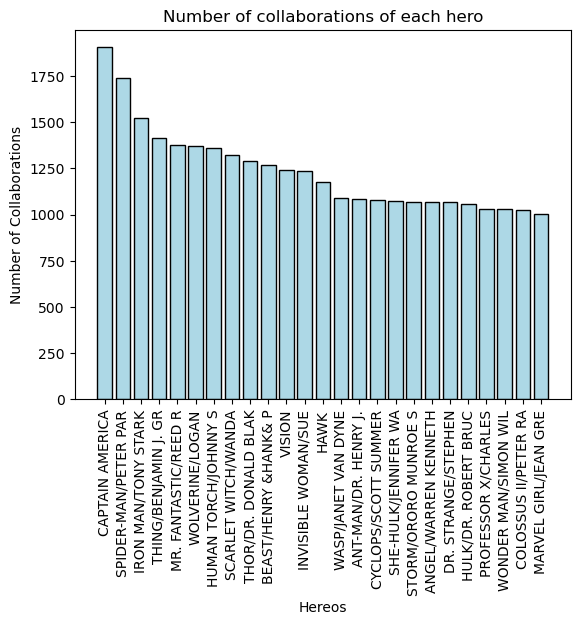

In [111]:
depicting_collaborations(heroes,1)

In [112]:
#4)

def depicting_heroes_in_comic(graph,type_): 
    if type_==2:
        comic={x: graph.degree[x] for x in graph.nodes if graph.nodes[x]['type']=='comic'}
        # sort the dictionary by values and store the result as a dataframe
        sort_dict = sorted(comic.items(), key=lambda x: -x[1])
        top25_comic= sort_dict[:25]
        #Extract the keys and values into separate lists
        keys, values = zip(*top25_comic)

        # Create the histogram
        plt.bar(keys,values,edgecolor='black',color='lightblue')

        # Add a title and labels for the x and y axes
        plt.title('Hereos apparitions for each comic')
        plt.xlabel('Comic')
        plt.ylabel('Number of Heroes in the comic')

        # Rotate the x-axis tick labels 90 degrees in order to be alble to see the 'comic_code'
        plt.xticks(rotation=90)

 
        
        plt.show()

      

        

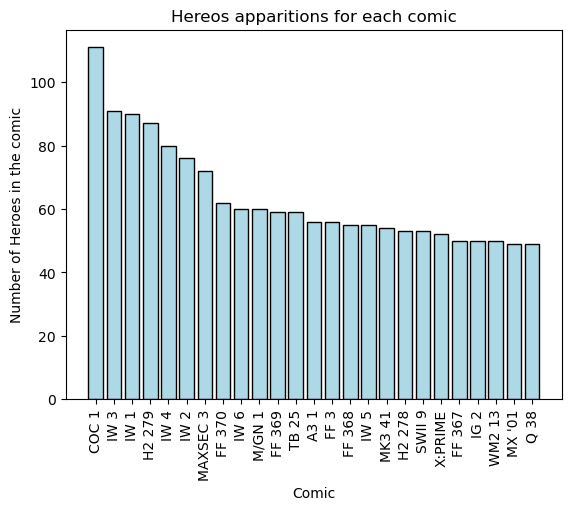

In [113]:
depicting_heroes_in_comic(comics,2)

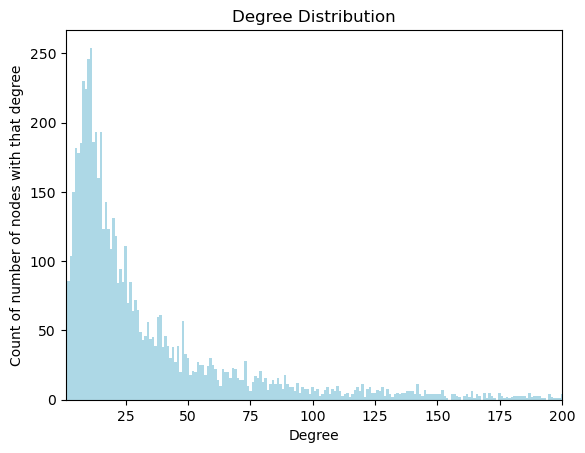

In [88]:
#5) degree distribution of the network
#visualize the dict sorted by its keys (degree of the nodes)

def depicting_distr_netw(graph):
    distribution=degree_distribution(graph)
    sort_distribution = dict(sorted(distribution.items(), key=lambda x: x[0]))

    #and let's visualize it with a suitable plot

    degrees, counts = zip(*sort_distribution.items())
    #return(type(sort_distribution))
    # Plot the histogram
    plt.bar(degrees, counts, width=1,color='lightblue')
    # Set the x-axis range in order to have a better visualization
    plt.xlim(1,200)
    plt.xlabel('Degree')
    plt.ylabel('Count of number of nodes with that degree')
    plt.title('Degree Distribution')

    plt.show()
    
depicting_distr_netw(heroes)

In [145]:
def visualization_1(graph_,type_,N):
    #takes N heroes with the above function
    graph=Remove_Not_TopN(graph_,N)
    
    print('• Report of the query of the user with visualizations: ', end='\n')
    
    make_table(graph) #this table is referred to the 
    print('')
    table_hubs(graph,type_)
    print('')
    if type_==2:
        depicting_heroes_in_comic(graph,type_)
    elif type_==1:
        depicting_collaborations(graph,type_)
    print('')
    depicting_distr_netw(graph)

• Report of the query of the user with visualizations: 
  N.Nodes    Density    AVG_degree  Kind_Graph
---------  ---------  ------------  ------------
      150   0.695839        103.68  dense

                   HUBS
0  SPIDER-MAN/PETER PAR
1       CAPTAIN AMERICA
2  MR. FANTASTIC/REED R
3  THING/BENJAMIN J. GR
4   INVISIBLE WOMAN/SUE
5  HUMAN TORCH/JOHNNY S



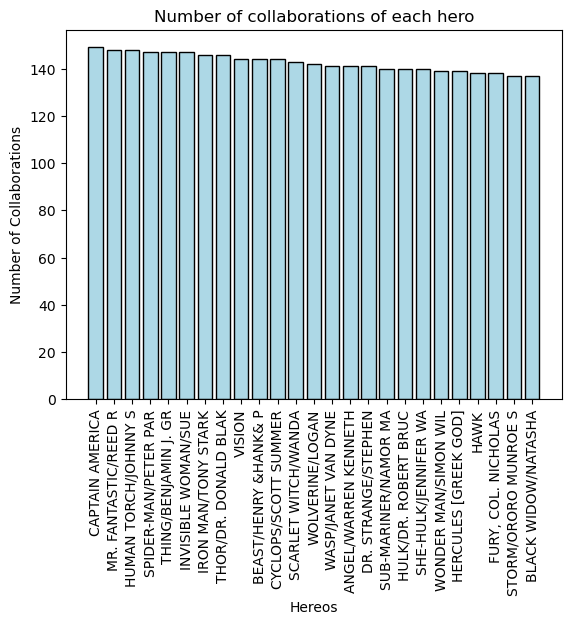

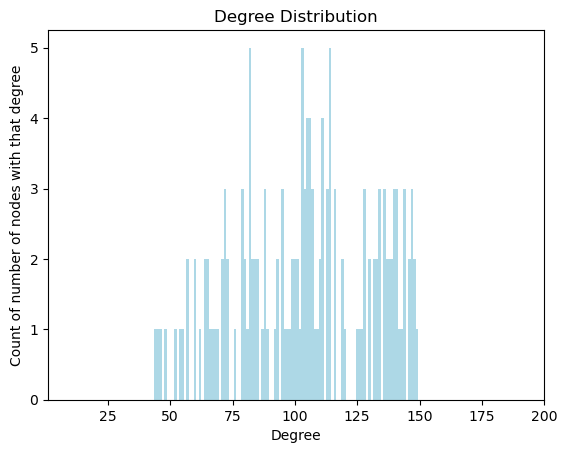

In [147]:
visualization_1(heroes,1,150) #notice that for a better visualization we set N=150.

# Functionality 2 - Find top superheroes!

In [8]:
# TODO: initial heroes graph, see if also works on new one with different weighting
'''
# initial heroes_graph
heroes_graph = nx.from_pandas_edgelist(hero_edge, 'hero1', 'hero2', create_using=nx.MultiGraph)

# counting edges for each node
nodes_edgecount = {}

for node in heroes_graph.nodes():
    nodes_edgecount[node] = len(heroes_graph.edges(node))
    
max_nr_edges = max(nodes_edgecount.values())


node_tuple_weight = {}
for e in heroes_graph.edges: # .edges() doesnt have the edge key and believe this is the third tuple entry necessary
    weight = 1-(nodes_edgecount[e[0]]+nodes_edgecount[e[1]])/(2*max_nr_edges)
    node_tuple_weight[(e[0], e[1], e[2])] = weight

nx.set_edge_attributes(heroes_graph, values = node_tuple_weight, name = 'weight')

'''

In [21]:
#returns every comics where a list of heroes appear
def filter_comics(n_heroes):
    filtered_comics = []
    for node in n_heroes:
        for e in comics.edges(node):
            if e[0] == node:
                if e[1] not in filtered_comics:
                    filtered_comics.append(e[1])
            elif e[1] == node:
                if e[0] not in filtered_comics:
                    filtered_comics.append(e[0])
    return filtered_comics

In [22]:
def find_top_superheroes(graph, node, metric, N):
    #creates the subgraph
    n_heroes = list(top_n_heroes[:N][:, 0])
    comics_to_subgraph = filter_comics(n_heroes) 
    subgraph = graph.subgraph(n_heroes + comics_to_subgraph)
    
    #nx.draw(subgraph)
    
    values = {}
    
    #calculates the values of the requested metric for each node
    if metric == 1:
        values = nx.betweenness_centrality(subgraph)
    elif metric == 2:
        values = nx.pagerank(subgraph)
    elif metric == 3:
        values = nx.closeness_centrality(subgraph)
    elif metric == 4:
        values = nx.degree_centrality(subgraph)
    else:
        return 0
    
    
    node_value = values[node]
    avg_value = sum(values.values()) / len(values)
    
    #creates the table
    df = pd.DataFrame([[avg_value], [node_value]], index=pd.Index(['average value', 'node value']), columns=['values'])
    
    return df

In [23]:
value = find_top_superheroes(comics, "IM2 6", 2, 3)

In [24]:
value

,values
average value,0.000290
node value,0.000226


# Functionality 3 - Shortest ordered Route

Functionality 3 takes the graph, a sequence of superheroes, an initial and a final node and integer N, the number of top N superheroes to consider.

It searches for the shortest path that connects the heroes via the comics in which they appear. 
Since the goal is to find the least number of comic nodes which have to be passed and we can return to visited nodes without cost we use the following approach: < br />
Conduct BFS starting from all visited nodes and stopping once next hero in sequence is found, then initialize a new search from all visited nodes to next hero...

In [23]:
'''
function returns a subgraph of top N heroes and if requested their directly neighbored nodes
    the adding of neighboring nodes is relevant for the comic network, 
    where the top N heroes would otherwise be unconnected
'''

def make_topnhero_graph(graph, N, neighbors = False):
    n_heroes = top_n_heroes[:N, 0]

    rel_nodes = list(n_heroes)
    if neighbors: # if should also add first neighbors of heroes
        for hero in n_heroes:
            [rel_nodes.append(n) for n in graph.neighbors(hero) if n not in rel_nodes]
        
    sub_graph = graph.subgraph(rel_nodes) # create subgraph with relevant nodes

    return sub_graph
    

In [18]:
''' 
bfs algorithm but store the sequence of visited nodes to reconstruct path
'''

def bfs(sub_comics, visited, seq, h_n):
    visited_cp = visited.copy() # each sub path must save visited nodes independently
    path_cp = [v for v in visited.keys() if visited[v]==True] # visited.copy()

    queue = [] # queue of visited nodes to start search from
    for p in path_cp:
        queue.append([p])
    
    while len(queue) != 0:
        curr_a = queue.pop(0) # complete path to first node from which search is started
        curr = curr_a[-1] # current node = last visited node in path
        
        if curr == h_n:
            return curr_a # actual path of interest
        
        for n in sub_comics.neighbors(curr):
            if visited_cp[n] == False and n not in seq:
                visited_cp[n] = True
                curr_n = curr_a.copy()
                curr_n.append(n)

                queue.append(curr_n)
     
    return 'heros not connected'+curr+'xxx'+h_n

In [32]:
def print_result_fct(sub_comics, paths):
    ordered = [] # list of visited nodes in order
    [ordered.append(l) for el in paths for l in el if l not in ordered]

    comic_list = [x for x,y in sub_comics.nodes(data=True) if y['tp']=='comic'] # all comic nodes in sub graph

    comics_to_read = [] # ordered list of comics to be read
    [comics_to_read.append(n) for n in ordered if n in comic_list]
    print(f'comics to read: {comics_to_read}')
    
    return ordered

In [33]:
''' 
function creates subgraph of top N heroes and direct neighbors
calls bfs:
     recursively searches paths until finds next heroes node
     returned shortest path is stored in paths list
all nodes in paths are marked as visited

'''
def functionality3(comics, test_h_seq, v_0, v_n, N):

    sub_comics = make_topnhero_graph(comics, N, True)
    visited = {}
    for n in sub_comics.nodes():
        visited[n] = False

    paths = []
    doable = True

    #
    seq = test_h_seq.copy()
    seq.append(v_n) # make sequence of all nodes that have to be visited
    #

    visited[v_0] = True

    while(len(seq)>0): # not all heros visited

        next_h = seq.pop(0) # next superhero to visit
        path_to_next_hero = bfs(sub_comics, visited, seq, next_h)

        if path_to_next_hero == 'heros not connected':
            print(path_to_next_hero)
            doable = False
            break

        for v in path_to_next_hero:
            visited[v] = True
            
        paths.append(path_to_next_hero)

    if doable:
        ordered = print_result_fct(sub_comics, paths) # printing result
        return sub_comics, ordered, paths


In [35]:
# testing 
test_h_seq = ['CAPTAIN AMERICA', 'UATU']
v_0 = 'SPIDER-MAN/PETER PAR'
v_n = 'JONES, RICHARD MILHO'


sub_comics, ordered, paths = functionality3(comics, test_h_seq, v_0, v_n, 200)

comics to read: ['A 11', 'A 101']


### Visualization 3

Drawing the whole graph of top N heros quickly becomes too complex. Even just plotting the nodes of the path and their direct neighbors in a test case resulted in an unexplainable chaos.

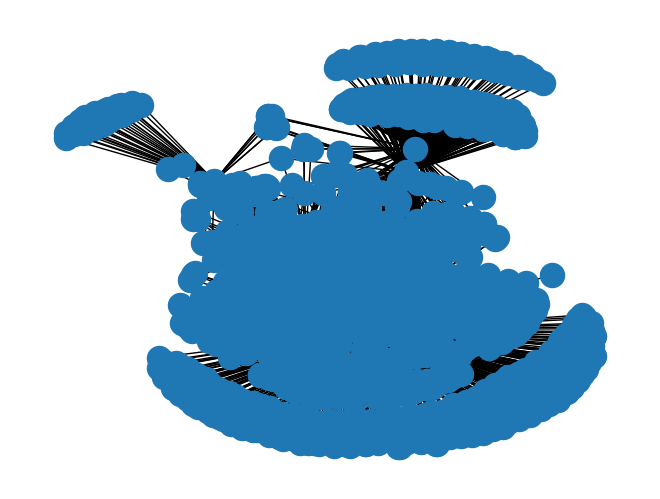

In [30]:
# trying to plot the path-nodes and their first neighbors
tbd_nodes = list(ordered)
for o in ordered:
    [tbd_nodes.append(n) for n in sub_comics.neighbors(o) if n not in tbd_nodes]

tbd_graph = sub_comics.subgraph(tbd_nodes)
nx.draw(tbd_graph)

So we plot just the path-nodes and their neighboring nodes, if these are also direct neighbors of other path-nodes.

In [36]:
tbd_nodes = list(ordered)
for o in ordered:
    [tbd_nodes.append(n) for n in sub_comics.neighbors(o)]

counter = defaultdict(int)

for tbd in tbd_nodes:
    counter[tbd] += 1

tbd = [k for k, v in counter.items() if v>1]
tbd_graph = sub_comics.subgraph(tbd)

In [96]:
# defining plot parameters for different nodes and edges

cols = [ 2 if n == v_0 else 2 if n == v_n else 1 if n in ordered else 0 for n in tbd_graph.nodes()]
node_sizes = np.array(cols)*60+30

path_edges = {} # dictionary of edges with the index of step if path of edge
j = 1
for ed in paths:
    for i in range(len(ed)-1): # should be ok because min len should be 3
        path_edges[(ed[i], ed[i+1])] = j
        j+=1
        
pos = nx.spring_layout(tbd_graph)

path_edgs = list(path_edges.keys()) # list of graph edges in path

edge_cols = ['red' if e in path_edgs else 'grey' for e in tbd_graph.edges()] # default edge color is grey, the edges that are on path are red
edge_width = [1 if e in path_edgs else 0.1 for e in tbd_graph.edges()]# width of to be path edges is highlighted


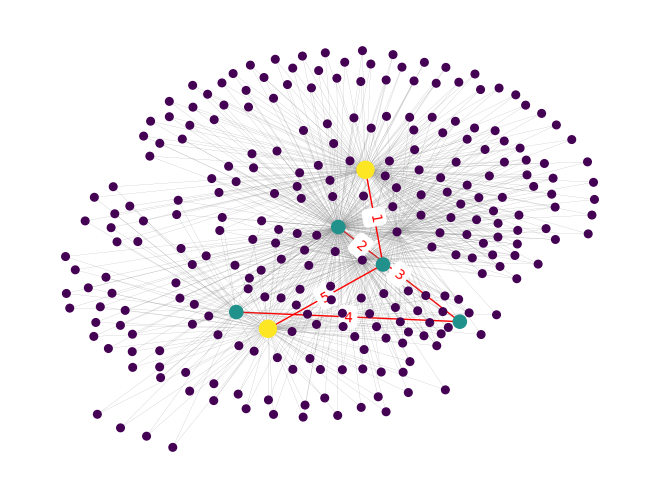

In [98]:
# nx.draw(tbd_graph)
plt.figure()

nx.draw(tbd_graph, pos, node_color = cols, with_labels=False, node_size = node_sizes, edge_color = edge_cols, width = edge_width)#, node_size = 100)

a = nx.draw_networkx_edge_labels(tbd_graph, pos, edge_labels=path_edges, font_color='red')

In [ ]:
'''
def check_if_disconnected(graph, h_0, h_n, hero_seq):
    visited = {}
    for n in graph.nodes():
        visited[n] = False

    visited[h_0] = True
    queue = []
    queue.append(h_0)

    heros = [h_0]+hero_seq+[h_n]

    while(len(queue) != 0 and len(heros)>0):
        curr = queue.pop(0)
        if curr in heros:
            heros.remove(curr)

        for n in graph.neighbors(curr):
            if visited[n] == False:
                visited[n] = True
                queue.append(n)
    
    if len(heros)>0:
        return 'heroes not connected'
        
        '''

# Functionality 4

- Functionality 4

In [20]:
#N: denoting the top N heroes that their data should be considered:

def Remove_Not_TopN(graph,N):
    #build the first part of the function to extract the nodes(heroes) that are not in the top N
    
    ls= edges.groupby(by = 'hero')['comic'].count().sort_values(ascending=False).index
    not_top_heroes = (ls[N:])
    
    #let's copy our graph in order to remove the heroes(node) that are not in top N 

    subgraph=graph.copy()
    subgraph.remove_nodes_from(not_top_heroes) 
    return(subgraph)

In [21]:
def functionality_4(graph_,heroA,heroB,N):
    #take the N hero of interest 
    graph=Remove_Not_TopN(heroes,10) 
    # Find the minimum number of links required to disconnect the graph into two subgraphs
    min_cut_edges = nx.minimum_edge_cut(graph,'THING/BENJAMIN J. GR', 'INVISIBLE WOMAN/SUE' ) #minimum_edge_cut is a function that determines the minimum number of edges that need to be removed from a graph to disconnect it
    print('• The minimum number of links (by considering their weights) required to disconnect the original graph in two disconnected subgraphs is '+ str(len(min_cut_edges)))

In [22]:
functionality_4(heroes,'IRON MAN/TONY STARK','HULK/DR. ROBERT BRUC',10) #with 2 example nodes (heroes)

• The minimum number of links (by considering their weights) required to disconnect the original graph in two disconnected subgraphs is 9


- Visualization 4

In [23]:
def visualization_4(graph_,heroA,heroB,N):
    #set plot dimension 
    plt.figure(figsize=(12, 6))
    
    #print original graph
    subgraph=Remove_Not_TopN(graph_,N)
    # node colors
    node_colors =['orchid' if node ==heroA  else 'green' if node == heroB  else 'lightblue' for node in subgraph.nodes()]
    plt.subplot(1, 2, 1)
    nx.draw_networkx(subgraph,node_size=500, node_color=node_colors, edge_color='red', width=0.1, with_labels=True)
    #print the minimum number of links required to disconnect the original graph in two disconnected subgraphs
    functionality_4(graph_,heroA,heroB,N)
    #remove the cutted edges
    min_cut_edges = nx.minimum_edge_cut(subgraph,heroA,heroB)
    subgraph.remove_edges_from(min_cut_edges)
    #print disconnected graph
    node_colors =['orchid' if node ==heroA  else 'green' if node == heroB  else 'lightblue' for node in subgraph.nodes()]
    plt.subplot(1, 2, 2)
    nx.draw_networkx(subgraph,node_size=500, node_color=node_colors, edge_color='red', width=0.1, with_labels=True)
    plt.suptitle('Strating Graphs and Disconnected Graph')
    
    plt.show()

• The minimum number of links (by considering their weights) required to disconnect the original graph in two disconnected subgraphs is 9


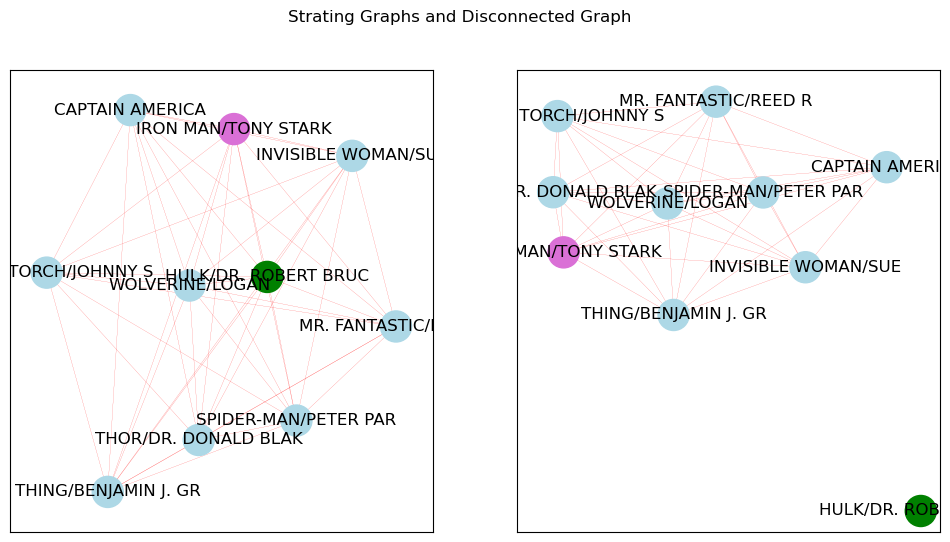

In [24]:
visualization_4(heroes,'IRON MAN/TONY STARK','HULK/DR. ROBERT BRUC',10)

The *minimum cut* of a weighted graph is defined as the minimum sum of weights of edges that, when removed from the graph, divide the graph into two sets.
This type of disconnection of the two graphs is probably due to the fact that our original graph is dense and high connected so the set of edges of minimum cardinality that disconnects the graph will disconnect just one node(hero, in the example above HULK) from the rest of the graph.
Notice that the minimum_edge_cut used in this functionality works using the ***Ford-Fulkerson*** algorithm: 
this algorithm work by finding the maximum flow between the two nodes, which is equal to the minimum cut of the graph. The maximum flow is equal to the minimum cut of the graph, which is the minimum number of edges that must be removed to disconnect the source node from the sink node (in our example from Iron Man to Hulk).

- *Time Complexity*: Time complexity of Ford-Fulkerson algorithm is O(max_flow * E). We run a loop while there is an augmenting path. In worst case, we may add 1 unit flow in every iteration. Therefore the time complexity becomes O(max_flow * E) where E= number of edges .

# Functionality 5 - Extracting Communities

We extract communities from a network of top N heroes. The functionality is built on a Girvan Nevman Algorithm as seen in [this article](https://www.analyticsvidhya.com/blog/2020/04/community-detection-graphs-networks/). <br/>
When testing the code we restrict the computation of edge betweenness centrality to a degree of 50. Trading off accuracy for computational time.

functionality5 calls the functions make_topnhero_graph, divide_graph and ebc.

In [318]:
'''
ebc() returns the graph edge with highest betweenness centrality
'''

def ebc(graph, degree): # degree < nr_nodes, makes function feasible
    ebc_dict = nx.edge_betweenness_centrality(graph, k=degree)
    ebc_l = [k for k, v in sorted(ebc_dict.items(), key=lambda item: item[1], reverse=True)] # sort edges by values of betweenness centrality
    return ebc_l[0] # return edge with highest betweenness centrality

In [337]:
''' 
called by main function5, constructs nr_comm communities from original graph
returns nodes for communities, list of removed_edges and split graph
'''

def divide_graph(o_graph, nr_comm = 2, degree = 10): # takes subgraph of top_n heroes, nr of commu
    graph = o_graph.copy()
    sg_count = nx.number_connected_components(graph)
    if sg_count > nr_comm:
        print(f'number of initial unconnected components{sg_count} is higher than goal {nr_comm}')
    removed_edges = []

    while(sg_count < nr_comm): # while number of communities is smaller than goal remove edge
        highest_ebc = ebc(graph, degree)# edge with highest betweenness centrality
        removed_edges.append(highest_ebc)
        graph.remove_edge(highest_ebc[0], highest_ebc[1])

        sg_count = nx.number_connected_components(graph) # count number of communities

    rest = nx.connected_components(graph) # graph of separated nr_comm communities

    return rest, removed_edges, graph

In [387]:
'''
function takes original graph, N number of top_n heroes to consider, two heroes, nr of communities to generate, max degree of betweenness centrality of edges to calculate
    generates sub_graph of top N heroes
    passes sub_graph to function divide_graph() which returns:
        nodes for each community
        list of removed edges
        the cut graph
    prints: nr_of edges removed and communities of hero1 & hero2
    returns: (same return values as divide_graph)
         copy of dictionary with values being lists of nodes
         list of removed edges
         the cut graph
'''

def functionality5(graph, N, hero1, hero2, nr_comm = 2, degree = 10):
    sub_heroes = make_topnhero_graph(graph, N, False) # make subgraph
    rest, removed_edges, cut_graph = divide_graph(sub_heroes, nr_comm, degree) # call executing function
    
    print(f'Number of edges removed to form {nr_comm} communities: {len(removed_edges)}\n')
    
    rest_copy = [c for c in rest] # copy returned list into rest_copy
    ass_comm = [] 
    i = 0
    for co in rest_copy: # loop through communities, append community of hero1&hero2
        if hero1 in co:
            ass_comm.append((hero1, i))
        if hero2 in co:
            ass_comm.append((hero2, i))
        i+=1
        
    print(f'{hero1} and {hero2} are assigned to {len(ass_comm)} communities') # print the number of communities of hero1&hero2 belong to

    return rest_copy, removed_edges, cut_graph

In [393]:
%%time
# call function5 on heroes, N=50, 'Captain America', 'Ironman/TONY STARK'
# to extract 4 communities while calculating edge betweenness centrality to degree=50
rest, removed_edges, cut_graph = functionality5(heroes, 50, 'CAPTAIN AMERICA', 'IRONMAN/TONY STARK', 4, 50)

Number of edges removed to form 4 communities: 124

CAPTAIN AMERICA and IRONMAN/TONY STARK are assigned to 1 communities
CPU times: user 2.7 s, sys: 74.7 ms, total: 2.77 s
Wall time: 2.87 s


### Visualization 5

We run functionality 5 on the top 50 heroes, generating 4 communities. All but one community contain 1 hero and one N-(4-1)*1 heroes.

In [384]:
# choosing parameters
N = 50
hero1 = 'CAPTAIN AMERICA'
hero2 =  'IRONMAN/TONY STARK'
n_comm = 4

hero_sel = top_n_heroes[:N, 0]
comm_assignment = [ n for i,n in enumerate(rest)]

df = pd.DataFrame(comm_assignment).T
df.columns = ['community '+str(i) for i in df.columns]
df.head(8)

,community 0,community 1,community 2,community 3
0,BLACK PANTHER/T'CHAL,CANNONBALL II/SAM GU,SHADOWCAT/KATHERINE,PUNISHER II/FRANK CA
1,"WATSON-PARKER, MARY",None,None,None
2,NIGHTCRAWLER/KURT WA,None,None,None
3,"JONES, RICHARD MILHO",None,None,None
4,ANGEL/WARREN KENNETH,None,None,None
5,PROFESSOR X/CHARLES,None,None,None
6,HAWK,None,None,None
7,QUICKSILVER/PIETRO M,None,None,None


In [378]:
# setting parameters for plotting of graph

sub_heroes = make_topnhero_graph(heroes, N, False)
comm_ass = {h:i for i, c in enumerate(rest) for h in c} # dictionary of node : community_index 

edge_cols = ['red' if e in removed_edges else 'grey' for e in sub_heroes.edges()] # default edge color is grey, the edges that are removed are red
edge_width = [1 if e in removed_edges else 0.05 for e in sub_heroes.edges()]# width of to be removed edges is highlited

node_colors =[comm_ass[node] for node in sub_heroes.nodes()] # nodes of same communities share color

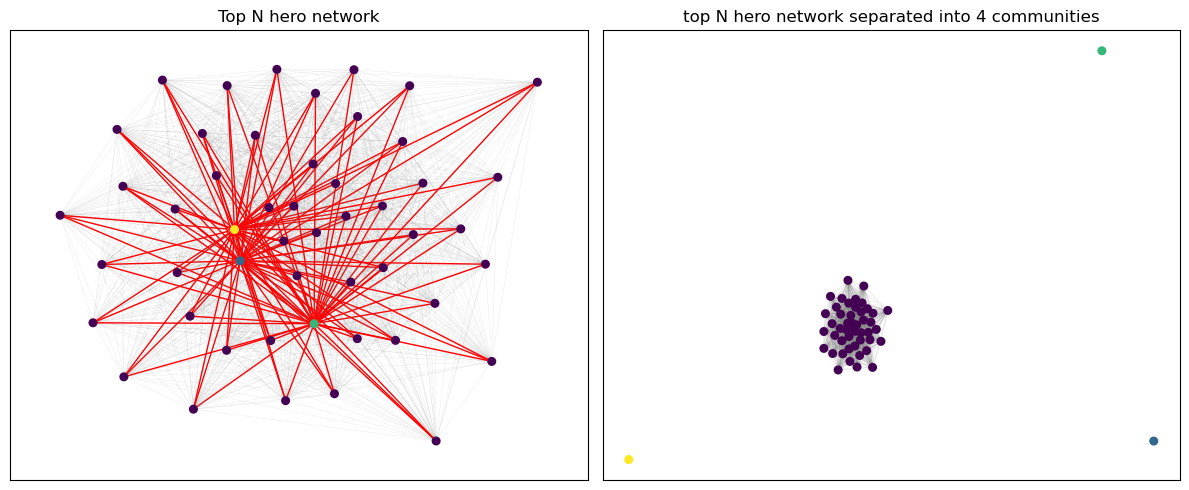

In [386]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
pos = nx.spring_layout(sub_heroes)
nx.draw_networkx(sub_heroes, pos, node_size=30, node_color=node_colors, edge_color=edge_cols, width=edge_width, with_labels=False, ax = ax[0])
ax[0].set_title('Top N hero network')

#sub_heroes_cut = sub_heroes.copy()
#sub_heroes_cut.remove_edges_from(removed_edges)
pos = nx.spring_layout(cut_graph)
nx.draw_networkx(cut_graph, pos, node_size=30, node_color=node_colors, edge_color='grey', width=0.1, with_labels=False, ax = ax[1])

ax[1].set_title(f'top N hero network separated into {n_comm} communities')
fig.tight_layout()

# 6. Algorithmic Question

In [3]:
import numpy as np

In [4]:
'''
do_path works recursively. arguments are: current position, boolean grid, a path in list format, count list, dicionary mapping char to vector

as long as path is not completed:
    copies path, grid and current position
    takes 1 step in the direction given by the first path element
    if the updated position is within boundaries and was not visited before:
        update grid
        - call do_path with the updated position, updated grid and updated path
        - continue in inital direction as long until out of grid boundries
'''

def do_path(current, grid, l_path, count, d):

    if len(l_path)==0: # if path is completed, stop, append 1 to count
        count.append(1)

    else: # if path is not completed
        c = current.copy() # without this DRU =-> 6
        lgrid = grid.copy() # local copy of grid
        path = l_path.copy() # local copy of left path
        s = path.pop(0) # next direction

        for i in range(1,3): # stepping once or twice into given direction
            c += d[s] # updating current position, d is dictionary
            try:
                if (2>=c[0]>=0) and (2>=c[1]>=0) and lgrid[tuple(c)]==True: # if new position within boundaries and not visited before
                    lgrid[tuple(c)] = False # set grid cell to False == visited
                    pgrid = lgrid.copy()
                    do_path(c, pgrid, path, count, d) # pass updated position, a copy of updated grid, path
                else:
                    break 
            except:
                break
            # if out of bound or visited break; two steps in the given direction won't be possible either


In [5]:
'''
call_paths takes a string as argument
a 3x3 boolean grid is initialized. True is unvisited, False implies the cell has been visited
calls the executing function do_path for copies of the grid and all possible initial positions
'''

def call_paths(string):

    d= {'L':np.array([0,-1]), 'R':np.array([0,1]), 'D':np.array([-1,0]), 'U':np.array([1,0])} # dictionary mapping char to vector

    ls = list(string) # string path as list

    count = [] # list to store finished paths

    arr = [True for i in range(3)] # constructing a 3x3 matrix of cells
    grid = np.array([arr for i in range(3)])

    for i in range(3):
        for j in range(3): # calling the do_path function starting from all 9 cells
            igrid = grid.copy() # copying the cell grid to avoid interference
            igrid[i,j] = False # setting initial cell to False
            do_path(np.array([i,j]), igrid, ls, count, d) # calling executing function
            
    print(sum(count))

In [6]:
call_paths('DRU') # testing algorithm with sample cases
call_paths('LDRDRUL')
call_paths('D')

15
0
9
